<h2>Introduction</h2>

Here you will find a step by step guide to downloading, configuring, and running the Einstein Toolkit. You may use this tutorial on a workstation or laptop, or on a supported cluster. Configuring the Einstein Toolkit on an unsupported cluster is beyond the scope of this tutorial. If you find something that does not work, please feel free to email users@einsteintoolkit.org.

This tutorial is very basic and does not describe the internal workings of the Einstein Toolkit. For a more detailed introduction, please have a look a the [text](https://arxiv.org/abs/1305.5299) provided by Miguel Zilhão and Frank Löffler and the [one](https://arxiv.org/abs/2011.13314) by Nicholas Choustikov.

<h2>Prerequisites</h2>
When using the Einstein Toolkit on a laptop or workstation you will want a number of packages installed in order to download, compile and use the Einstein Toolkit components. If this is a machine which you control (i.e. you have root), you can install using one of the recipes that follow:

On Mac, please first 
- Install [Xcode](https://itunes.apple.com/us/app/xcode/id497799835) from the Apple [App Store](https://itunes.apple.com/us/app/xcode/id497799835). In *addition* agree to Xcode license and install the Xcode Command Line Tools in Terminal 
```bash
sudo xcodebuild -license
sudo xcode-select --install
```
- when using MacPorts
  - install MacPorts for your version of the Mac operating system, if you have not already installed it (https://www.macports.org/install.php). 
  - Next, please install the following packages, using the commands:
```bash
sudo port -N install pkgconfig gcc11 openmpi-gcc11 fftw-3 gsl jpeg zlib openssl bash subversion ld64 hdf5 +fortran +gfortran
sudo port select mpi openmpi-gcc11-fortran
sudo port select gcc mp-gcc11
```
- when using HomeBrew
  - install HomeBrew for your version of the Mac operating system, if you have not already installed it (https://brew.sh/). 
  - Next, please install the following packages, using the commands:
```bash
brew install fftw gcc gsl hdf5 hwloc jpeg open-mpi openssl zlib pkg-config bash subversion
```

On Debian/Ubuntu/Mint use this command (the strange syntax is to suport all three of them):
```bash
$(sudo -l sudo) su -c 'apt-get update'
$(sudo -l sudo) su -c 'apt-get install -y subversion gcc git numactl libgsl-dev libpapi-dev python3 python-is-python3 python3-pip libhwloc-dev libudev-dev make libopenmpi-dev libhdf5-openmpi-dev libfftw3-dev libssl-dev liblapack-dev g++ curl gfortran patch pkg-config libhdf5-dev libjpeg-turbo?-dev'
```

On Fedora use this command:
```bash
sudo dnf install -y libjpeg-turbo-devel gcc git lapack-devel make subversion gcc-c++ which papi-devel perl python3 python3-pip hwloc-devel openmpi-devel hdf5-openmpi-devel openssl-devel libtool-ltdl-devel numactl-devel gcc-gfortran findutils hdf5-devel fftw-devel patch gsl-devel pkgconfig
module load mpi/openmpi-x86_64
```
You will have to repeat the `module load` command once in each new shell each time you would like to compile or run the code. You may have to log out and back in for the module command to become visible.

On Centos use this command:
```bash
su -c 'yum install -y epel-release'
su -c 'yum install --enablerepo=crb -y libjpeg-turbo-devel gcc git lapack-devel make subversion gcc-c++ which python3 python3-pip papi-devel hwloc-devel openmpi-devel openssl-devel libtool-ltdl-devel numactl-devel gcc-gfortran fftw-devel patch gsl-devel perl'
module load mpi/openmpi-x86_64
```
You will have to repeat the `module load` command once in each new shell each time you would like to compile or run the code. You may have to log out and back in for the module command to become visible.

On OpenSuse use this command:
```bash
sudo zypper install -y curl gcc git lapack-devel make subversion gcc-c++ which python3 python3-pip papi-devel hwloc-devel openmpi-devel libopenssl-devel libnuma-devel gcc-fortran hdf5-devel libfftw3-3 patch gsl-devel pkg-config
mpi-selector --set  $(mpi-selector --list | head -n1)
```
You will only have to execute the `mpi-selector` once, after that log out and back in to make the `mpirun` and `mpicc` commands visible without which Cactus will compile very slowly and fail to run.

On Windows 10/11 please install the Ubuntu Linux subsystem, then follow the instructions for a Ubuntu system. [These](https://docs.microsoft.com/en-us/windows/wsl/install) are Microsoft's official instructions on how to do so, [Ubuntu](https://ubuntu.com/wsl#install-ubuntu-on-wsl) provides an alternative version. You may also want to install native ssh client like [Putty](https://www.chiark.greenend.org.uk/~sgtatham/putty/) and an X11 server like [VcXsrv](https://sourceforge.net/projects/vcxsrv/), [XMing](https://sourceforge.net/projects/xming/) or an all-in-one solution for X11 server and ssh client like [MobaXterm](https://mobaxterm.mobatek.net/).

## Notebook setup
This notebook is intended to be used online on the Einstein Toolkit tutorial server, offline as a read-only document, as a jupyter notebook that you can download and also in your own docker container using `nds-org/jupyter-et`. To make all of these work some setting need to be tweaked, which we do in the next cell.

In [3]:
# this allows you to use "cd" in cells to change directories instead of requiring "%cd"
%automagic on
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

# this (non-default package) keeps the end of shell output in view
try: import scrolldown
except ModuleNotFoundError: pass

# We are going to install kuibit, a Python package to post-process Cactus simulations.
# We will install kuibit inside the Cactus directory. The main reason for this is to
# have a make easier to uninstall kuibit (you can just remove the Cactus folder). 
import os, sys
os.environ["PYTHONUSERBASE"] = os.environ['HOME'] + "/Cactus/python"
sys.path.insert(1, f"{os.environ['PYTHONUSERBASE']}/lib/python{sys.version_info[0]}.{sys.version_info[1]}/site-packages")


Automagic is ON, % prefix IS NOT needed for line magics.


<b>Note:</b> By default, the cells in this notebook are Python commands. However, cells that start with <code>%%bash</code> are executed in a bash shell. If you wish to run these commands outside the notebook and in a bash shell, cut and paste only the part after the initial <code>%%bash</code>. 

## Optimized Download/Build Experience
Downloading the source code from github in a classroom setting, where lots of users are doing the same thing at the same time, can create network problems, and compiling the complete ET from scratch can take up to half an hour.

The next cell will create a complete pre-built ET checkout in your home directory, speeding up subsequent cells.  This step is optional, but should allow you to execute the notebook in less time.

**Note:** This will only work in the docker image or on the tutorial server.

In [4]:
%%bash
[ -r ~etuser/Cactus.tar.gz ] && ! [ -d ~/Cactus ] && tar -xzf ~etuser/Cactus.tar.gz -C ~/

<h2>Download</h2>

A script called GetComponents is used to fetch the components of the Einstein Toolkit. GetComponents serves as convenient wrapper around lower level tools like git and svn to download the codes that make up the Einstein toolkit from their individual repositories. You may download and make it executable as follows:

In [5]:
cd ~/

/home/nadinekuo


In [6]:
%%bash
curl -kLO https://raw.githubusercontent.com/gridaphobe/CRL/ET_2022_05/GetComponents
chmod a+x GetComponents

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   980    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0k  100   98k    0     0   292k      0 --:--:-- --:--:-- --:--:--  293k


GetComponents accepts a thorn list as an argument. To check out the needed components:

In [7]:
%%bash
./GetComponents https://bitbucket.org/einsteintoolkit/manifest/raw/ET_2022_05/einsteintoolkit.th

Do you want to update all existing components? yes, no [no] : ^C


In [8]:
cd ~/Cactus

/home/nadinekuo/Cactus


<h2>Configure and build</h2>

The recommended way to compile the Einstein Toolkit is to use the Simulation Factory ("SimFactory").
<h3>Configuring SimFactory for your machine</h3>

The ET depends on various libraries, and needs to interact with machine-specific queueing systems and MPI implementations. As such, it needs to be configured for a given machine. For this, it uses SimFactory. Generally, configuring SimFactory means providing an optionlist, for specifying library locations and build options, a submit script for using the batch queueing system, and a runscript, for specifying how Cactus should be run, e.g. which mpirun command to use.

In [9]:
%%bash
./simfactory/bin/sim setup-silent



Here we will define some necessary Simulation Factory defaults.


Determining local machine name: DESKTOP-CFJ01HF.localdomain

--------------------SUMMARY--------------------:


[default]
user            = nadinekuo
email           = nadinekuo
allocation      = NO_ALLOCATION


------------------END SUMMARY------------------:

Contents successfully written to /home/nadinekuo/Cactus/repos/simfactory2/etc/defs.local.ini


After this step is complete you will find your machine's default setup under ./simfactory/mdb/machines/&lt;hostname &gt;.ini
You can edit some of these settings freely, such as "description", "basedir" etc. Some entry edits could result in simulation start-up warnings and/or errors such as "ppn" (processor-per-node meaning number of cores on your machine), "num-threads" (number of threads per core) so such edits must be done with some care.

<h2>Building the Einstein Toolkit</h2>

Assuming that SimFactory has been successfully set up on your machine, you should be able to build the Einstein Toolkit with the command below. The option "-j2" sets the make command that will be used by the script. The number used is the number of processes used when building. Even in parallel, this step may take a while, as it compiles all the thorns specified in thornlists/einsteintoolkit.th.

Note: Using too many processes to compile on the test machine may result in compiler failures, if the system runs out of memory.

In [10]:
%%bash
./simfactory/bin/sim build -j2 --thornlist thornlists/einsteintoolkit.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.12.0
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   ADMAnalysis
           Requires:          CartGrid3D 
   ADMBase
           Requires:          CartGrid3D 
   ADMCoupling
   ADMDerivatives
           Requires thorns:   SummationByParts
   ADMMacros
           Provides:          ADMMacros 
   ADMMass
   AEILocalInterp
   AHFinder
           Requires:          CartGrid3D 
   AHFinderDirect
           Optional:          HDF5 
           Requires thorns:   SpaceMask
   BLAS
           Provides:          BLAS 
   Baikal
   BaikalVacuum
   Boundary
           Provides:          Boundary 
   CT_Analytic
           Requires:          GenericFD 
           Optional:          LoopControl 
   CT_MultiLevel
           Requires:          Carpet MPI 
   Cactus
           Optional:          MPI 
   CalcK
           Requires:          CartGrid3D 

<h2>Running a simple example</h2>

You can now run the Einstein Toolkit with a simple test parameter file.

In [11]:
%%bash
./simfactory/bin/sim create-run helloworld \
    --parfile arrangements/CactusExamples/HelloWorld/par/HelloWorld.par

Parameter file: /home/nadinekuo/Cactus/arrangements/CactusExamples/HelloWorld/par/HelloWorld.par
Error: cannot create job skeleton directory: Simulation "/home/nadinekuo/simulations/helloworld" already exists and has been initialized
Aborting Simfactory.


The above command will run the simulation naming it "helloworld" and display its log output to screen.

If you see <pre>INFO (HelloWorld): Hello World!</pre> anywhere in the above output, then congratulations, you have successfully downloaded, compiled and run the Einstein Toolkit! You may now want to try some of the other tutorials to explore some interesting physics examples.

### Run ET with Poisson gallery parameter file


In [12]:
# This file will have to be created first
%%bash
./simfactory/bin/sim create-run poissonexample \
    --parfile arrangements/CactusExamples/Poisson/par/poisson.par

Error: specified parfile "arrangements/CactusExamples/Poisson/par/poisson.par" does not exist or is not readable
   tried paths "/home/nadinekuo/Cactus/arrangements/CactusExamples/Poisson/par/poisson.par"
   and "/home/nadinekuo/Cactus/repos/simfactory2/etc/parfiles/arrangements/CactusExamples/Poisson/par/poisson.par",
   working directory is "/home/nadinekuo/Cactus"
Aborting Simfactory.


<h2>Running single star simulation</h2>

What follows is the much more computationally intensive example of simulating a static TOV star. Just below this cell you can see the contents of a Cactus parameter file to simulate a single, spherical symmetric star using the Einstein Toolkit. The parameter file has been set up to run to completion in about 10 minutes, making it useful for a tutorial but too coarsely resolved to do science with it.

Run the cell to write its content to `par/tov_ET.par` so that it can be used for a short simulation. (This file is created by `cat >` under `simulations/tov_ET/SIMFACTORY`)

In [13]:
%%bash
cat >par/tov_ET.par <<"#EOF"
# Example parameter file for a static TOV star. Everything is evolved, but
# because this is a solution to the GR and hydro equations, nothing changes
# much. What can be seen is the initial perturbation (due to numerical errors)
# ringing down (look at the density maximum), and later numerical errors
# governing the solution. Try higher resolutions to decrease this error.

# Some basic stuff
ActiveThorns = "Time MoL"
ActiveThorns = "Coordbase CartGrid3d Boundary StaticConformal"
ActiveThorns = "SymBase ADMBase TmunuBase HydroBase InitBase ADMCoupling ADMMacros"
ActiveThorns = "IOUtil"
ActiveThorns = "Formaline"
ActiveThorns = "SpaceMask CoordGauge Constants LocalReduce aeilocalinterp LoopControl"
ActiveThorns = "Carpet CarpetLib CarpetReduce CarpetRegrid2 CarpetInterp"
ActiveThorns = "CarpetIOASCII CarpetIOScalar CarpetIOHDF5 CarpetIOBasic"

# Finalize
Cactus::terminate           = "time"
Cactus::cctk_final_time     = 400 #800 # divide by ~203 to get ms

# Termination Trigger
ActiveThorns = "TerminationTrigger"
TerminationTrigger::max_walltime = 24          # hours
TerminationTrigger::on_remaining_walltime = 0  # minutes
TerminationTrigger::check_file_every = 512
TerminationTrigger::termination_file = "TerminationTrigger.txt"
TerminationTrigger::termination_from_file   = "yes"
TerminationTrigger::create_termination_file = "yes"

# grid parameters
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type         = "coordbase"
CartGrid3D::domain       = "full"
CartGrid3D::avoid_origin = "no"
CoordBase::xmin =  0.0
CoordBase::ymin =  0.0
CoordBase::zmin =  0.0
CoordBase::xmax = 24.0
CoordBase::ymax = 24.0
CoordBase::zmax = 24.0
# Change these parameters to change resolution. The ?max settings above
# have to be multiples of these. 'dx' is the size of one cell in x-direction.
# Making this smaller means using higher resolution, because more points will
# be used to cover the same space.
CoordBase::dx   =   2.0
CoordBase::dy   =   2.0
CoordBase::dz   =   2.0

CarpetRegrid2::regrid_every =   0
CarpetRegrid2::num_centres  =   1
CarpetRegrid2::num_levels_1 =   2
CarpetRegrid2::radius_1[1]  = 12.0


CoordBase::boundary_size_x_lower        = 3
CoordBase::boundary_size_y_lower        = 3
CoordBase::boundary_size_z_lower        = 3
CoordBase::boundary_size_x_upper        = 3
CoordBase::boundary_size_y_upper        = 3
CoordBase::boundary_size_z_upper        = 3
CoordBase::boundary_shiftout_x_lower    = 1
CoordBase::boundary_shiftout_y_lower    = 1
CoordBase::boundary_shiftout_z_lower    = 1
CoordBase::boundary_shiftout_x_upper    = 0
CoordBase::boundary_shiftout_y_upper    = 0
CoordBase::boundary_shiftout_z_upper    = 0


ActiveThorns = "ReflectionSymmetry"

ReflectionSymmetry::reflection_x = "yes"
ReflectionSymmetry::reflection_y = "yes"
ReflectionSymmetry::reflection_z = "yes"
ReflectionSymmetry::avoid_origin_x = "no"
ReflectionSymmetry::avoid_origin_y = "no"
ReflectionSymmetry::avoid_origin_z = "no"

# storage and coupling
TmunuBase::stress_energy_storage = yes
TmunuBase::stress_energy_at_RHS  = yes
TmunuBase::timelevels            =  1
TmunuBase::prolongation_type     = none


HydroBase::timelevels            = 3

ADMMacros::spatial_order = 4

SpaceMask::use_mask      = "yes"

Carpet::enable_all_storage       = no
Carpet::use_buffer_zones         = "yes"

Carpet::poison_new_timelevels    = "yes"
Carpet::check_for_poison         = "no"

Carpet::init_3_timelevels        = no
Carpet::init_fill_timelevels     = "yes"

CarpetLib::poison_new_memory = "yes"
CarpetLib::poison_value      = 114

# system specific Carpet paramters
Carpet::max_refinement_levels    = 10
driver::ghost_size               = 3
Carpet::prolongation_order_space = 3
Carpet::prolongation_order_time  = 2

# Time integration
time::dtfac = 0.25

MoL::ODE_Method             = "rk4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

# check all physical variables for NaNs
#  This can save you computing time, so it's not a bad idea to do this
#  once in a whioe.
ActiveThorns = "NaNChecker"
NaNChecker::check_every = 16384
NaNChecker::action_if_found = "terminate" #"terminate", "just warn", "abort"
NaNChecker::check_vars = "ADMBase::metric ADMBase::lapse ADMBase::shift HydroBase::rho HydroBase::eps HydroBase::press HydroBase::vel"

# Hydro paramters

ActiveThorns = "EOS_Omni GRHydro"

HydroBase::evolution_method      = "GRHydro"

GRHydro::riemann_solver         = "Marquina"
GRHydro::GRHydro_eos_type       = "Polytype"
GRHydro::GRHydro_eos_table      = "2D_Polytrope"
GRHydro::recon_method           = "ppm"
GRHydro::GRHydro_stencil        = 3
GRHydro::bound                  = "none"
GRHydro::rho_abs_min            = 1.e-10
# Parameter controlling finite difference order of the Christoffel symbols in GRHydro
GRHydro::sources_spatial_order  = 4

# Curvature evolution parameters

ActiveThorns = "GenericFD NewRad"
ActiveThorns = "ML_BSSN ML_BSSN_Helper"
ADMBase::evolution_method        = "ML_BSSN"
ADMBase::lapse_evolution_method  = "ML_BSSN"
ADMBase::shift_evolution_method  = "ML_BSSN"
ADMBase::dtlapse_evolution_method= "ML_BSSN"
ADMBase::dtshift_evolution_method= "ML_BSSN"

ML_BSSN::timelevels = 3

ML_BSSN::harmonicN           = 1      # 1+log
ML_BSSN::harmonicF           = 2.0    # 1+log
ML_BSSN::evolveA             = 1
ML_BSSN::evolveB             = 1
# NOTE: The following parameters select geodesic slicing. This choice only enables you to evolve stationary spacetimes.
#       They will not allow you to simulate a collapsing TOV star.
ML_BSSN::ShiftGammaCoeff     = 0.0
ML_BSSN::AlphaDriver         = 0.0
ML_BSSN::BetaDriver          = 0.0
ML_BSSN::advectLapse         = 0
ML_BSSN::advectShift         = 0
ML_BSSN::MinimumLapse        = 1.0e-8

ML_BSSN::my_initial_boundary_condition = "extrapolate-gammas"
ML_BSSN::my_rhs_boundary_condition     = "NewRad"

# Some dissipation to get rid of high-frequency noise
ActiveThorns = "SphericalSurface Dissipation"
Dissipation::verbose   = "no"
Dissipation::epsdis   = 0.01
Dissipation::vars = "
        ML_BSSN::ML_log_confac
        ML_BSSN::ML_metric
        ML_BSSN::ML_curv
        ML_BSSN::ML_trace_curv
        ML_BSSN::ML_Gamma
        ML_BSSN::ML_lapse
        ML_BSSN::ML_shift
"


# init parameters
InitBase::initial_data_setup_method = "init_some_levels"

# Use TOV as initial data
ActiveThorns = "TOVSolver"

HydroBase::initial_hydro         = "tov"
ADMBase::initial_data            = "tov"
ADMBase::initial_lapse           = "tov"
ADMBase::initial_shift           = "tov"
ADMBase::initial_dtlapse         = "zero"
ADMBase::initial_dtshift         = "zero"

# Parameters for initial star
TOVSolver::TOV_Rho_Central[0] = 1.28e-3
TOVSolver::TOV_Gamma          = 2
TOVSolver::TOV_K              = 100

# Set equation of state for evolution
EOS_Omni::poly_gamma                   = 2
EOS_Omni::poly_k                       = 100
EOS_Omni::gl_gamma                     = 2
EOS_Omni::gl_k                         = 100


# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir             = ${parfile}

# Write one file overall per output (variable/group)
# In production runs, comment this or set to "proc" to get one file
# per MPI process
IO::out_mode            = "onefile"

# Some screen output
IOBasic::outInfo_every = 512
IOBasic::outInfo_vars  = "Carpet::physical_time_per_hour HydroBase::rho{reductions='maximum'}"

# Scalar output
IOScalar::outScalar_every    = 512
IOScalar::one_file_per_group = "yes"
IOScalar::outScalar_reductions = "norm1 norm2 norm_inf sum maximum minimum"
IOScalar::outScalar_vars     = "
 HydroBase::rho{reductions='maximum'}
 HydroBase::press{reductions='maximum'}
 HydroBase::eps{reductions='minimum maximum'}
 HydroBase::vel{reductions='minimum maximum'}
 HydroBase::w_lorentz{reductions='minimum maximum'}
 ADMBase::lapse{reductions='minimum maximum'}
 ADMBase::shift{reductions='minimum maximum'}
 ML_BSSN::ML_Ham{reductions='norm1 norm2 maximum minimum norm_inf'}
 ML_BSSN::ML_mom{reductions='norm1 norm2 maximum minimum norm_inf'}
 GRHydro::dens{reductions='minimum maximum sum'}
 Carpet::timing{reductions='average'}
"

# 1D ASCII output. Disable for production runs!
IOASCII::out1D_every        = 2048
IOASCII::one_file_per_group = yes
IOASCII::output_symmetry_points = no
IOASCII::out1D_vars         = "
 HydroBase::rho
 HydroBase::press
 HydroBase::eps
 HydroBase::vel
 ADMBase::lapse
 ADMBase::metric
 ADMBase::curv
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
"

# 2D HDF5 output
CarpetIOHDF5::output_buffer_points = "no"

CarpetIOHDF5::out2D_every = 2048
CarpetIOHDF5::out2D_vars = "
 HydroBase::rho
 HydroBase::eps
 HydroBase::vel
 HydroBase::w_lorentz
 ADMBase::lapse
 ADMBase::shift
 ADMBase::metric
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
 "
#EOF

#### Poisson gallery example: Write contents of simulation parameter list to poisson.par

In [14]:
%%bash
cat >par/poisson.par <<"#EOF"

######################################
# Flesh parameters
######################################

Cactus::cctk_run_title = "Solving Poisson's equation with CT_MultiLevel (multigrid setup, FMG)"

Cactus::cctk_full_warnings         = yes
Cactus::highlight_warning_messages = no
Cactus::cctk_timer_output          = "off"

Cactus::terminate       = "any"
Cactus::cctk_initial_time = 0
Cactus::cctk_final_time = 0
Cactus::cctk_itlast     = 0
Cactus::presync_mode = "mixed-error" 

# First statement should be active thorns
#############################################################################################
ActiveThorns = "Boundary CartGrid3D CoordBase Slab SymBase"
#############################################################################################

CoordBase::domainsize = "minmax"

CoordBase::xmin =  -1.00
CoordBase::ymin =  -1.00
CoordBase::zmin =  -1.00
CoordBase::xmax =  +1.00
CoordBase::ymax =  +1.00
CoordBase::zmax =  +1.00
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25
CoordBase::dz   =  0.25

CoordBase::boundary_size_x_lower     = 3
CoordBase::boundary_size_y_lower     = 3
CoordBase::boundary_size_z_lower     = 3
CoordBase::boundary_size_x_upper     = 3
CoordBase::boundary_size_y_upper     = 3
CoordBase::boundary_size_z_upper     = 3

CoordBase::boundary_shiftout_x_lower = 1
CoordBase::boundary_shiftout_y_lower = 1
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_x_upper = 1
CoordBase::boundary_shiftout_y_upper = 1
CoordBase::boundary_shiftout_z_upper = 1

CartGrid3D::type = "coordbase"

##################################################################################
ActiveThorns = "IOUtil Carpet CarpetLib CarpetInterp LoopControl CarpetReduce CarpetSlab SystemTopology"
##################################################################################

Carpet::adaptive_stepsize = "no"

Carpet::schedule_barriers = no
CarpetLib::output_bboxes  = no
Carpet::init_fill_timelevels = "yes"

Carpet::domain_from_coordbase = yes
Carpet::max_refinement_levels = 6
#Carpet::time_refinement_factors         = "[1,2,4,8]"

driver::ghost_size       = 3
Carpet::use_buffer_zones = yes

Carpet::prolongation_order_space = 5
Carpet::prolongation_order_time  = 2

Carpet::convergence_level = 0

Carpet::poison_new_timelevels = yes
CarpetLib::poison_new_memory  = yes
CarpetLib::poison_value       = 250

Carpet::output_timers_every      = 0

#CarpetLib::max_allowed_memory_MB = 12288

##################################################################
ActiveThorns = "CarpetRegrid2"
##################################################################

CarpetRegrid2::num_centres  = 5

CarpetRegrid2::num_levels_1 = 6
CarpetRegrid2::position_x_1 = -0.5
CarpetRegrid2::position_y_1 = -0.5
CarpetRegrid2::radius_1[1]  = 5
CarpetRegrid2::radius_1[2]  = 5
CarpetRegrid2::radius_1[3]  = 5
CarpetRegrid2::radius_1[4]  = 5
CarpetRegrid2::radius_1[5]  = 0.4
CarpetRegrid2::radius_1[6]  = 0.4
CarpetRegrid2::radius_1[7]  = 0.4

CarpetRegrid2::num_levels_2 = 6
CarpetRegrid2::position_x_2 = -0.1
CarpetRegrid2::position_y_2 = -0.1
CarpetRegrid2::radius_2[1]  = 5
CarpetRegrid2::radius_2[2]  = 5
CarpetRegrid2::radius_2[3]  = 5
CarpetRegrid2::radius_2[4]  = 5
CarpetRegrid2::radius_2[5]  = 0.2
CarpetRegrid2::radius_2[6]  = 0.2
CarpetRegrid2::radius_2[7]  = 0.2

CarpetRegrid2::num_levels_3 = 6
CarpetRegrid2::position_x_3 = 0.5
CarpetRegrid2::position_y_3 = 0.5
CarpetRegrid2::radius_3[1]  = 5
CarpetRegrid2::radius_3[2]  = 5
CarpetRegrid2::radius_3[3]  = 5
CarpetRegrid2::radius_3[4]  = 5
CarpetRegrid2::radius_3[5]  = 0.2
CarpetRegrid2::radius_3[6]  = 0.2
CarpetRegrid2::radius_3[7]  = 0.2

CarpetRegrid2::num_levels_4 = 6
CarpetRegrid2::position_x_4 = -0.6
CarpetRegrid2::position_y_4 = 0
CarpetRegrid2::radius_4[1]  = 5
CarpetRegrid2::radius_4[2]  = 5
CarpetRegrid2::radius_4[3]  = 5
CarpetRegrid2::radius_4[4]  = 5
CarpetRegrid2::radius_4[5]  = 0.8
CarpetRegrid2::radius_4[6]  = 0.8
CarpetRegrid2::radius_4[7]  = 0.8

CarpetRegrid2::num_levels_5 = 6
CarpetRegrid2::position_x_5 = 0.6
CarpetRegrid2::position_y_5 = -0.3
CarpetRegrid2::radius_5[1]  = 5
CarpetRegrid2::radius_5[2]  = 5
CarpetRegrid2::radius_5[3]  = 5
CarpetRegrid2::radius_5[4]  = 5
CarpetRegrid2::radius_5[5]  = 0.8
CarpetRegrid2::radius_5[6]  = 0.8
CarpetRegrid2::radius_5[7]  = 0.8

#################################
ActiveThorns = "AEILocalInterp"
ActiveThorns = "Fortran"
ActiveThorns = "GenericFD"
ActiveThorns = "HDF5"
ActiveThorns = "InitBase"
ActiveThorns = "LocalInterp"
#################################

#################################
ActiveThorns = "MoL Time"
#################################

MoL::ODE_Method             = "RK4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

Time::dtfac   = 0.2


###################################################################################################
ActiveThorns = "CT_MultiLevel CT_Analytic"
###################################################################################################

CT_MultiLevel::cycle_type          = "FMG cycle"
CT_MultiLevel::tol                 = 1e-12
CT_MultiLevel::omega               = 1
CT_MultiLevel::fd_order            = 4
CT_MultiLevel::output_norms        = "yes"
CT_MultiLevel::nrelsteps_down      = 200
CT_MultiLevel::nrelsteps_up        = 200
CT_MultiLevel::nrelsteps_bottom    = 200
CT_MultiLevel::nrelsteps_top       = 200
CT_MultiLevel::topMGlevel          = 5
CT_MultiLevel::compare_to_exact    = "yes"
CT_MultiLevel::exact_solution_gfname[0] = "CT_Analytic::epsi"
CT_MultiLevel::exact_laplacian_gfname[0] = "CT_Analytic::elaplacian"

CT_MultiLevel::n0[0]               = 0
CT_MultiLevel::inipsi_gfname[0]    = "CT_Analytic::testinipsi"
CT_MultiLevel::cxx_gfname[0]       = "CT_Analytic::testcxx"
CT_MultiLevel::cyy_gfname[0]       = "CT_Analytic::testcyy"
CT_MultiLevel::czz_gfname[0]       = "CT_Analytic::testczz"
CT_MultiLevel::c0_gfname[0]        = "CT_Analytic::testc0"

CT_Analytic::free_data             = "exact"
CT_Analytic::ampG                  = 1
CT_Analytic::amp[0]                = 1
CT_Analytic::x0[0]                 = -0.5
CT_Analytic::y0[0]                 = -0.5
CT_Analytic::sigmax[0]             = 0.2
CT_Analytic::sigmay[0]             = 0.2
CT_Analytic::sigmaz[0]             = 0.2
CT_Analytic::amp[1]                = 1
CT_Analytic::x0[1]                 = -0.1
CT_Analytic::y0[1]                 = -0.1
CT_Analytic::sigmax[1]             = 0.1
CT_Analytic::sigmay[1]             = 0.1
CT_Analytic::sigmaz[1]             = 0.1
CT_Analytic::amp[2]                = 1
CT_Analytic::x0[2]                 = 0.5
CT_Analytic::y0[2]                 = 0.5
CT_Analytic::sigmax[2]             = 0.1
CT_Analytic::sigmay[2]             = 0.1
CT_Analytic::sigmaz[2]             = 0.1
CT_Analytic::amp[3]                = 1
CT_Analytic::x0[3]                 = -0.6
CT_Analytic::y0[3]                 = 0
CT_Analytic::sigmax[3]             = 0.4
CT_Analytic::sigmay[3]             = 0.4
CT_Analytic::sigmaz[3]             = 0.4
CT_Analytic::amp[4]                = 1
CT_Analytic::x0[4]                 = 0.6
CT_Analytic::y0[4]                 = -0.3
CT_Analytic::sigmax[4]             = 0.4
CT_Analytic::sigmay[4]             = 0.4
CT_Analytic::sigmaz[4]             = 0.4

CT_Analytic::other_timelevels      = 3

#################################
ActiveThorns = "CarpetIOBasic"
#################################

IOBasic::outInfo_every      = 1
IOBasic::outInfo_reductions = "norm2"
IOBasic::outInfo_vars       = "
	CT_MultiLevel::psi
	CT_MultiLevel::residual
        Carpet::physical_time_per_hour
"

#################################
ActiveThorns = "CarpetIOScalar"
#################################

# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir = $parfile

IOScalar::one_file_per_group = yes

IOScalar::outScalar_every = 0
IOScalar::outScalar_vars  = "
"

#################################
ActiveThorns = "CarpetIOASCII"
#################################

IOASCII::one_file_per_group = yes

IOASCII::output_symmetry_points = no
IOASCII::out3D_ghosts           = no

IOASCII::out0D_criterion = "divisor"
IOASCII::out0D_every = 0
IOASCII::out0D_vars  = "
"

IOASCII::output_all_timelevels = "no"
IOASCII::out1D_criterion = "divisor"
IOASCII::out1D_every = 1
IOASCII::out1D_vars  = "
	CT_MultiLevel::psi
	CT_MultiLevel::coeffs
	CT_MultiLevel::residual
	CT_MultiLevel::err
	CT_Analytic::testinipsi
	CT_Analytic::testc0
	CT_Analytic::epsi
"

IOASCII::out2D_every = 0
IOASCII::out2D_criterion = "divisor"
IOASCII::out2D_vars  = "
"

IOASCII::out3D_every = 0
IOASCII::out3D_criterion = "divisor"
IOASCII::out3D_vars  = "
	CT_MultiLevel::psi
	CT_MultiLevel::coeffs
"

#################################
Activethorns = "CarpetIOHDF5"
#################################

IOHDF5::out_criterion = "divisor"
IOHDF5::out_every          = 1
IOHDF5::one_file_per_group = yes
IOHDF5::compression_level  = 0
IOHDF5::out_vars  = "
	CT_MultiLevel::psi
	CT_MultiLevel::err
	CT_MultiLevel::residual
	CT_Analytic::testc0
"

IOHDF5::checkpoint          = "yes"
IO::checkpoint_dir          = $parfile
IO::checkpoint_ID           = "yes"
IO::checkpoint_every        = 1280
IO::checkpoint_on_terminate = "yes"
IO::checkpoint_keep         = 2

IO::recover     = "autoprobe"
IO::recover_dir = $parfile

/bin/bash: line 312: warning: here-document at line 0 delimited by end-of-file (wanted `#EOF')


Simfactory maintain the concept of a self-contained "simulation" which is identified by a name and stores its parameter file, executable and other related files. Once a simulation has been created individual simulation segments can be submitted using the stored executable and parameter file.

In [15]:
%%bash
# create simulation directory structure
./simfactory/bin/sim create tov_ET --configuration sim --parfile=par/tov_ET.par

Parameter file: /home/nadinekuo/Cactus/par/tov_ET.par
Error: cannot create job skeleton directory: Simulation "/home/nadinekuo/simulations/tov_ET" already exists and has been initialized
Aborting Simfactory.


The `create` command sets up the simulation directory skeleton. It copies the executable, parameter file as well as Simfactory's queuing scripts.

In [16]:
%%bash
# create simulation directory structure
./simfactory/bin/sim create poisson_ET --configuration sim --parfile=par/poisson.par

Parameter file: /home/nadinekuo/Cactus/par/poisson.par
Skeleton Created
Job directory: "/home/nadinekuo/simulations/poisson_ET"
Executable: "/home/nadinekuo/Cactus/exe/cactus_sim"
Option list: "/home/nadinekuo/simulations/poisson_ET/SIMFACTORY/cfg/OptionList"
Submit script: "/home/nadinekuo/simulations/poisson_ET/SIMFACTORY/run/SubmitScript"
Run script: "/home/nadinekuo/simulations/poisson_ET/SIMFACTORY/run/RunScript"
Parameter file: "/home/nadinekuo/simulations/poisson_ET/SIMFACTORY/par/poisson.par"


In [17]:
%%bash
# start simulation segment
./simfactory/bin/sim submit tov_ET --cores=2 --num-threads=1 --walltime=0:20:00

Assigned restart id: 1 
Executing submit command: exec nohup /home/nadinekuo/simulations/tov_ET/output-0001/SIMFACTORY/SubmitScript < /dev/null > /home/nadinekuo/simulations/tov_ET/output-0001/tov_ET.out 2> /home/nadinekuo/simulations/tov_ET/output-0001/tov_ET.err & echo $!
Submit finished, job id is 7744


The `submit` command submitted a new segment for the simulation `tov_ET` to the queueing system to run in the background asking for a maximum runtime of 20 minutes, using a total of 2 compute cores and using 1 thread per MPI ranks. On your laptop it will start right away, on a cluster the queuing system will wait until a sufficient number of nodes is able to start your simulation.

You can check the status of the simulation with the command below. You can run this command repeatedly until the job shows <pre>[ACTIVE (FINISHED)...</pre> as its state. Prior to that, it may show up as QUEUED or RUNNING.

In [18]:
%%bash
# start simulation segment
./simfactory/bin/sim submit poisson_ET --cores=2 --num-threads=1 --walltime=0:20:00

Assigned restart id: 0 
Executing submit command: exec nohup /home/nadinekuo/simulations/poisson_ET/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/nadinekuo/simulations/poisson_ET/output-0000/poisson_ET.out 2> /home/nadinekuo/simulations/poisson_ET/output-0000/poisson_ET.err & echo $!
Submit finished, job id is 7784


In [22]:
%%bash
./simfactory/bin/sim list-simulations tov_ET

   tov_ET                  [ACTIVE (RUNNING), restart 0001, job id 7744]


In [24]:
%%bash
./simfactory/bin/sim list-simulations poisson_ET

   poisson_ET              [ACTIVE (RUNNING), restart 0000, job id 7784]


 To watch a simulation's log output use the `show-output` command of simfactory. **Interrupt the kernel** (or press `CTRL-C` if copying & pasting these commands to a terminal) if you wish to stop watching.

In [15]:
%%bash
# watch log output, following along as new output is produced
./simfactory/bin/sim show-output --follow tov_ET

Simulation name: tov_ET
==> tov_ET.out <==
Iteration      Time | *me_per_hour | *ROBASE::rho
                    |              |      maximum
-------------------------------------------------
    81920    80.000 | 2.246235e+03 |    0.0012509
    82432    80.500 | 2.243097e+03 |    0.0012511
    82944    81.000 | 2.247046e+03 |    0.0012513
    83456    81.500 | 2.250998e+03 |    0.0012515
    83968    82.000 | 2.248574e+03 |    0.0012516
    84480    82.500 | 2.246062e+03 |    0.0012518
    84992    83.000 | 2.248197e+03 |    0.0012520
    85504    83.500 | 2.251185e+03 |    0.0012522
    86016    84.000 | 2.245707e+03 |    0.0012523
    86528    84.500 | 2.241365e+03 |    0.0012525
    87040    85.000 | 2.243891e+03 |    0.0012527
    87552    85.500 | 2.246421e+03 |    0.0012529
    88064    86.000 | 2.243098e+03 |    0.0012530
    88576    86.500 | 2.240080e+03 |    0.0012532
    89088    87.000 | 2.243929e+03 |    0.0012534
    89600    87.500 | 2.246803e+03 |    0.0012536
    901

You can leave out the `--follow` option if you would like to see all output up to this point.

In [26]:
%%bash
# watch log output, following along as new output is produced
./simfactory/bin/sim show-output --follow poisson_ET

Simulation name: poisson_ET
==> poisson_ET.out <==
   CT_MULTILEVEL::ct_c4[0]
   CT_MULTILEVEL::ct_a0[0]
   CT_MULTILEVEL::ct_a1[0]
   CT_MULTILEVEL::ct_a2[0]
   CT_MULTILEVEL::ct_a3[0]
   CT_MULTILEVEL::ct_a4[0]
INFO (MoL): Using Runge-Kutta 4 as the time integrator.
INFO (MoL): The maximum number of evolved variables is 384. 0 are registered.
INFO (MoL): The maximum number of slow evolved variables is 384. 0 are registered.
INFO (MoL): The maximum number of constrained variables is 384. 0 are registered.
INFO (MoL): The maximum number of SandR variables is 384. 0 are registered.
INFO (MoL): The maximum number of evolved array variables is 384. 0 are registered.
INFO (MoL): The maximum number of constrained array variables is 384. 0 are registered.
INFO (MoL): The maximum number of SandR array variables is 384. 0 are registered.
INFO (MoL): The maximum size of any array variables is 0.
INFO (Vectors): Testing vectorisation... [errors may result in segfaults]
INFO (Vectors): 375/375 te

## Managing submitted simulations

Since the `submit` command was used to start the  simulation, it is running in the background and you have to use simfactory commands to interact with it. The next cell shows how to list simulations.

**Remember** that you have to interrupt the kernel to stop `show-output` and be able to execute the cells below.

In [35]:
%%bash
./simfactory/bin/sim list-simulations

   helloworld              [ACTIVE (FINISHED), restart 0000, job id -1]
   poisson_ET              [ACTIVE (FINISHED), restart 0000, job id 7784]
   testsuite-2procs-1thread-01   [ACTIVE (FINISHED), restart 0000, job id 335]
   tov_ET                  [ACTIVE (FINISHED), restart 0001, job id 7744]


Simfactory offers a `stop` command to abort a running simulation. The next cell has the command intentionally commented out to prevent accidental stopping of your very first simulation.

In [17]:
%%bash
#./simfactory/bin/sim stop tov_ET

after this the simulation changes to the "FINISHED" state indicating it is no longer running.

Simulations that are no longer needed are removed using the `purge` command. The next cell has the command intentionally commented out to prevent accidental removing of your very first simulation.

In [18]:
%%bash
#./simfactory/bin/sim purge tov_ET

Simfactory creates all output for a simulation in a set of output directories, one for each restart from a checkpoint. You can find out its location using `get-output-dir`.

In [19]:
%%bash
./simfactory/bin/sim get-output-dir tov_ET

/home/nadinekuo/simulations/tov_ET/output-0000


In [28]:
%%bash
./simfactory/bin/sim get-output-dir poisson_ET

/home/nadinekuo/simulations/poisson_ET/output-0000


<h2>Plotting the Output</h2>

The simplest way to analyze a simulation is using [kuibit](https://sbozzolo.github.io/kuibit/). a Python package for post-processing and visualization. `kuibit` is part of the Einstein Toolkit, but has to be installed separately. You can install `kuibit` with `pip3`. This will take care of all the required dependencies.

In [29]:
%%bash
# We install kuibit inside the Cactus folder so that if you wish to
# remove kuibit you can simply remove the folder. You can ignore the
# following line if you want to install kuibit along your other python
# packages.
export PYTHONUSERBASE="$HOME/Cactus/python"
pip3 install -U --user kuibit==1.3.5

Requirement already up-to-date: kuibit==1.3.5 in ./python/lib/python3.8/site-packages (1.3.5)


`kuibit` is a Python library: you can use it in Python scripts/notebooks to inspect and post-process your simulations. `kuibit` has rich [documentation](https://sbozzolo.github.io/kuibit) and tutorials to get use the package. Here, we are going to show only a few features.

The Einstein Toolkit comes with several [kuibit examples](https://sbozzolo.github.io/kuibit/#examples) that are ready to be used. The examples are available in the `utils/Analysis/kuibit/examples` folder. Most of these codes are command-line scripts that produce plots. 

For example, two common plots are for timeseries and for grid variables. For those, we can use the `plot_timeseries.py` and `plot_grid_var.py` codes:

### Dependency installations that were missing:

In [30]:
# Added this since the next piece of code requires these libraries.
import sys
!{sys.executable} -m pip install matplotlib_inline & pip install ipython

In [37]:

# Plot the second column of 
# terr_norm_eqn0.asc
#
# On our Lmod system, python 3.6.3 is default but for numpy and
# matplotlib need to execute
# module load GCC/6.4.0-2.28  OpenMPI/2.1.1 numpy/1.13.1-Python-3.6.3
# module load matplotlib/2.1.0-Python-3.6.3
#

import numpy as np
import matplotlib.pyplot as plt

ifname = 'terr_norm_eqn0.asc'

errs = np.loadtxt(ifname, usecols=(1), unpack=True)

figs, ax = plt.subplots()

ax.plot(errs, '-', label='')

ax.set_yscale('log')
ax.set_xlabel('Iteration number')
ax.set_ylabel('Solution error')
ax.set_title('2nd column {0}'.format(ifname))
ax.grid(True)

if 1:
    plt.savefig('poisson_errs.png')

plt.show()


FileNotFoundError: terr_norm_eqn0.asc not found.

In [45]:

%%bash
# Plot a timeseries with the maximum of the density
./utils/Analysis/kuibit/examples/bins/plot_timeseries.py \
--datadir $HOME/simulations/tov_ET --variable "rho" --reduction "maximum" \
--outdir $HOME/simulations/tov_ET

# Plot a 2D slice of the rest-mass density (which does not support reflection 
# symmetry, see below). 
#`-x0` and `-x1` define the region we want to plot: they coordinates of the 
# lower left and top right corners. 
#When not specified, the latest available iteration is plotted. 
./utils/Analysis/kuibit/examples/bins/plot_grid_var.py \
--datadir $HOME/simulations/tov_ET --variable "rho" -x0 0 0 -x1 10 10 \
--outdir  $HOME/simulations/tov_ET --logscale --multilinear-interpolate \
--colorbar

The outputs are two images named `rho_maximum.png` and `rho_xy.png` saved in the folder of the simulation.
Let's have a look at them

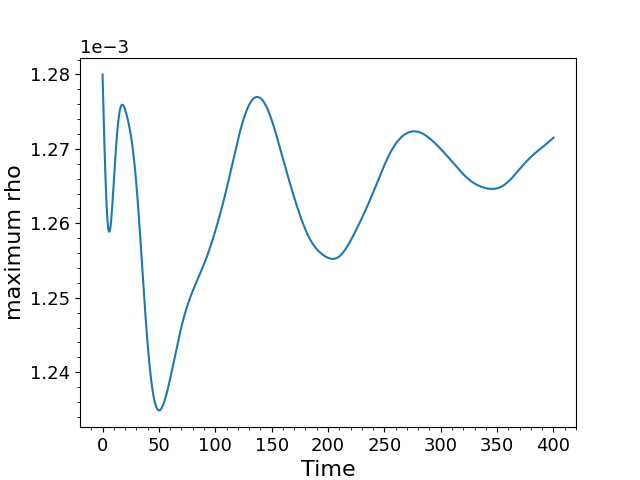

In [43]:
from IPython.display import Image

# datadir is the top-level directory that contains that data for
# a given simulation.
datadir = os.environ["HOME"]+"/simulations/tov_ET"
Image(filename=os.path.join(datadir, "rho_maximum.png"))

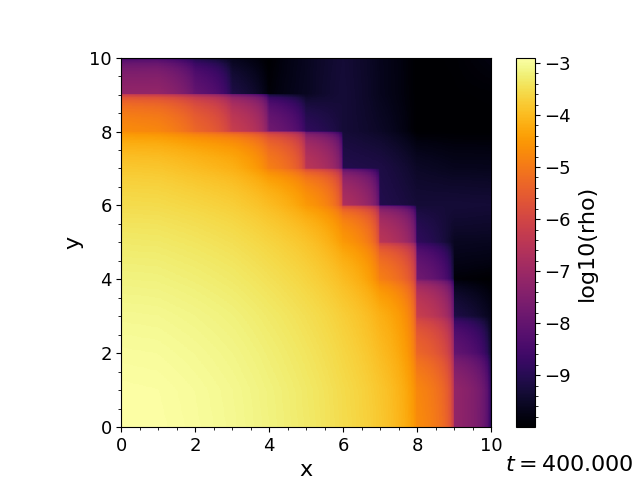

In [46]:
Image(filename=os.path.join(datadir, "rho_xy.png"))

While the examples are handy and have lots of options, often we want full control. For that, we use `kuibit` as a library. Let's see how we can make plots similar to the ones we generated with the examples. First, we import what we need:

In [44]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz

The main interface to simulation data in `kuibit` is the `SimDir`. It contains all the information that `kuibit` can extract from the output. `SimDir` takes as input the top level folder of the output. 

In [ ]:
sim = SimDir(datadir)
# This will print a list with all the data available
print(sim)

Let's plot the maximum pressure and compare it with the pressure as computed from the maximum density.

In [ ]:
rho = sim.timeseries.maximum['rho']
press = sim.timeseries.maximum['press']

# Polytropic constants
K, Gamma = 100, 2

# Timeseries in kuibit support all the algebraic operations
cold_press = K * rho**Gamma

plt.ylabel("Pressure")
plt.xlabel("Time")
plt.plot(cold_press, label="cold_press")
plt.plot(press, label="press", ls="dashed")
plt.legend()

max_diff = abs(press - cold_press).max()

print(f"Max difference {max_diff:.3e}")

Let's plot an equatorial slice of the rest-mass density at the initial iteration.

In [ ]:
iteration_number = 0
rho_xy = sim.gridfunctions.xy["rho"][iteration_number]

# We cannot plot rho_xy directly because it contains all
# the information for the various refinement levels. 
# We need to resample the data onto a uniform grid.

# shape is the resolution at which we resample
# x0, x1 are the bottom left and top right coordiantes
# that we want to consider

# Here we choose x0=[0,0] because we have reflection 
# symmetry

# resample=True activates multilinear resampling

rho_xy_unif = rho_xy.to_UniformGridData(shape=[100, 100], 
                                        x0=[0,0],
                                        x1=[10, 10],
                                        resample=True)

# Undo reflection symmetry on the x axis
rho_xy_unif.reflection_symmetry_undo(dimension=0)
# Undo reflection symmetry on the y axis
rho_xy_unif.reflection_symmetry_undo(dimension=1)

viz.plot_color(rho_xy_unif,
               logscale=True,
               colorbar=True,
               label="rho",
               xlabel="x",
               ylabel="y",
              )

The image is pixelated because the resolution of our simulation is very low.

Finally, we can compare our data with some reference values.

In [ ]:
# this cell shows the expected plot using previously stored data
import numpy as np

# reconstruct plot data from saved strings
(quant_diff_s, minval, maxval, delta_t) = \
  ("ff8baee2e5d2ac70320c0007182c404f5b656f7b8897a8bbcddde8eeede8ddcfc0b0a29589817b777473757a8189929ca6b0bac4cbd0d3d4d4d2cfcbc7c2bdb8b4b0adaaa9a8a9abaeb3b8bcc1c5c8cccf",
   1.235e-03, 1.280e-03, 5.000e+00)
quant_diff = np.array(bytearray.fromhex(quant_diff_s))
rec_vals = quant_diff / 255. * (maxval- minval) + minval
rec_time = np.arange(0,len(quant_diff)) * delta_t

# plot them, including your results if you have them
plt.plot(rec_time, rec_vals/rec_vals[0],
         label="central density (stored values)")
try: plt.plot(rho/rho(0), label="central density (your results)")
except: pass
plt.xlabel(r'$t$ [$M_{\odot}$]');
plt.ylabel(r'$\rho_c / \rho_c(0)$');
plt.legend(loc='lower right');

Running the cell above will produce a plot of the expected results as well as your own results.
![Central density(stored value)](https://github.com/nds-org/jupyter-et/raw/master/data/tov_ET.png)

In [ ]:
# create small dataset to show what plot should look like
def sparsify(lin_data, sparsity):
    # drop unwanted datapoint
    sparse_data = lin_data[::sparsity,:]
    
    # compute min, max of dataset then difference to minimum and quantize to 8 bit precisison
    minval = np.amin(sparse_data[:,2])
    maxval = np.amax(sparse_data[:,2])
    print("minval:",minval)
    print("maxval:",maxval)
    diff = sparse_data[:,2] - minval
    quant_diff = np.minimum(np.maximum(np.round(diff / (maxval - minval) * 255.5), 0), 255).astype('int')

    # timesteps are equidistant and start at 0 so we only need the stepsize
    delta_t = sparse_data[1,1] - sparse_data[0,1]

    # string rep of 8bit differences
    quant_diff_s = ""
    for i in quant_diff: quant_diff_s += "%02x" % i
    
    print ('"%s", %.3e, %.3e, %.3e' % (quant_diff_s, minval, maxval, delta_t))

# create a low fidelity representation of every 10th datapoint and output all data a string
sparsify(np.array([rho.t,rho.x,rho.y]).transpose(), 10)    

In [1]:
%%bash
cd ~/Cactus
./simfactory/bin/sim create-submit --procs 2 --num-threads 1 --testsuite testsuite-2procs-1thread-01
# watch output
./simfactory/bin/sim show-output --follow testsuite-2procs-1thread-01

Skeleton Created
Job directory: "/home/nadinekuo/simulations/testsuite-2procs-1thread-01"
Option --testsuite given
Executable: "/home/nadinekuo/Cactus/exe/cactus_sim"
Option list: "/home/nadinekuo/simulations/testsuite-2procs-1thread-01/SIMFACTORY/cfg/OptionList"
Submit script: "/home/nadinekuo/simulations/testsuite-2procs-1thread-01/SIMFACTORY/run/SubmitScript"
Run script: "/home/nadinekuo/simulations/testsuite-2procs-1thread-01/SIMFACTORY/run/RunScript"
Assigned restart id: 0 


Copying testsuite data
Executing submit command: exec nohup /home/nadinekuo/simulations/testsuite-2procs-1thread-01/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/nadinekuo/simulations/testsuite-2procs-1thread-01/output-0000/testsuite-2procs-1thread-01.out 2> /home/nadinekuo/simulations/testsuite-2procs-1thread-01/output-0000/testsuite-2procs-1thread-01.err & echo $!
Submit finished, job id is 335
Simulation name: testsuite-2procs-1thread-01
==> testsuite-2procs-1thread-01.out <==
Simulation name: testsuite-2procs-1thread-01
Running simulation testsuite-2procs-1thread-01
Running test suite sim-testsuite

==> testsuite-2procs-1thread-01.err <==

==> testsuite-2procs-1thread-01.out <==

  -------------------------------
   Cactus Code Test Suite Tool
  -------------------------------

Parameter file test-table in thorn TestTable but no output directory
Parameter file small in thorn Carpet but no output directory
Parameter file carpetintegrate-tapered in thorn CarpetIntegrateTest